# Install Transformers Library

In [ ]:
!pip install transformers==3

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

In [30]:
 from google.colab import drive
 
#  drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [31]:
root_path = 'gdrive/MyDrive/dataset_interface/FinalDataset.csv'

In [32]:
df = pd.read_csv(root_path)
df=df[["Category","Description"]]
df

,Category,Description
0,Content,Fantastic program! Instant search results and...
1,Content,Great browser nice and fast. Please add force...
2,Uniformity,The best and Light-weight browser on Android....
3,Uniformity,Thank you dev. Love the ui. Love the smooth...
4,Navigation,Yeah... I'm greedy. First and foremost - supp...
...,...,...
2393,Content,I am only giving this app three star because s...
2394,Content,its so helpfull for me having online class u c...
2395,Interactivity,Very nice up... It could be best if sending vo...
2396,LoadingSpeed,"Why when I want to send files, images, videos ..."


In [33]:
df['label'] = df['Category'].astype('category').cat.codes
df.head(10)

,Category,Description,label
0,Content,Fantastic program! Instant search results and...,2
1,Content,Great browser nice and fast. Please add force...,2
2,Uniformity,The best and Light-weight browser on Android....,8
3,Uniformity,Thank you dev. Love the ui. Love the smooth...,8
4,Navigation,Yeah... I'm greedy. First and foremost - supp...,5
5,LoadingSpeed,Do not be fooled. This is a very useful brows...,4
6,Accessibility,Within a minute of trying the free version I ...,0
7,Interactivity,I'll need a few days of usage to make an info...,3
8,Content,For me this is the best browser hands down! It...,2
9,ColorScheme,Needs a few additions to make it as good as t...,1


In [34]:
df.label.unique()

array([2, 8, 5, 4, 0, 3, 1, 6, 7], dtype=int8)

# Load Dataset

In [35]:
df.shape

(2398, 3)

In [36]:
# check class distribution
df['label'].value_counts(normalize = True)

2    0.259383
3    0.226022
6    0.156797
1    0.105088
8    0.078816
0    0.073394
7    0.069224
5    0.018349
4    0.012927
Name: label, dtype: float64

# Split train dataset into train, validation and test sets

In [37]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['Description'], df['label'], 
                                                                    random_state=2023, 
                                                                    test_size=0.3, 
                                                                    stratify=df['label'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2023, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

# Import BERT Model and BERT Tokenizer

In [38]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [39]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [40]:
# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


# Tokenization

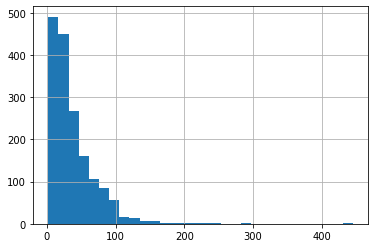

In [41]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [42]:
max_seq_len = 100

In [43]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# Convert Integer Sequences to Tensors

In [44]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# Create DataLoaders

In [45]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 64

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Freeze BERT Parameters

In [46]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

# Define Model Architecture

In [47]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.8)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      self.dropout = nn.Dropout(0.8)
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,9)
      self.dropout = nn.Dropout(0.8)
      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [48]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [49]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

# Find Class Weights

In [50]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight(class_weight = "balanced", classes= np.unique(train_labels), y= train_labels)


print(class_wts)

[1.51580849 1.05335844 0.42860792 0.49193785 8.47474747 6.01433692
 0.70891424 1.60727969 1.41245791]


In [51]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 500

# Fine-Tune BERT

In [52]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [53]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

# Start Model Training

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 500

Evaluating...

Training Loss: 2.403
Validation Loss: 2.243

 Epoch 2 / 500

Evaluating...

Training Loss: 2.256
Validation Loss: 2.203

 Epoch 3 / 500

Evaluating...

Training Loss: 2.223
Validation Loss: 2.224

 Epoch 4 / 500

Evaluating...

Training Loss: 2.215
Validation Loss: 2.202

 Epoch 5 / 500

Evaluating...

Training Loss: 2.207
Validation Loss: 2.199

 Epoch 6 / 500

Evaluating...

Training Loss: 2.223
Validation Loss: 2.202

 Epoch 7 / 500

Evaluating...

Training Loss: 2.201
Validation Loss: 2.192

 Epoch 8 / 500

Evaluating...

Training Loss: 2.194
Validation Loss: 2.199

 Epoch 9 / 500

Evaluating...

Training Loss: 2.215
Validation Loss: 2.193

 Epoch 10 / 500

Evaluating...

Training Loss: 2.209
Validation Loss: 2.201

 Epoch 11 / 500

Evaluating...

Training Loss: 2.202
Validation Loss: 2.193

 Epoch 12 / 500

Evaluating...

Training Loss: 2.199
Validation Loss: 2.193

 Epoch 13 / 500

Evaluating...

Training Loss: 2.216
Validation Loss: 2.187

 Epoch 

# Load Saved Model

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

# Get Predictions for Test Data

In [ ]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

In [ ]:
# confusion matrix
pd.crosstab(test_y, preds)